# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dependencies

In [ ]:
!pip install unidecode

In [ ]:
train_df_path           = "data/train.tsv"
test_df_path            = "data/test.tsv"
test_stage_2_df_path    = "data/test_stg2.tsv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import unidecode
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from nltk.stem import PorterStemmer 
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import csr_matrix
from nltk import word_tokenize, pos_tag, ne_chunk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
import itertools
import multiprocessing
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import gc

num_cores = multiprocessing.cpu_count()
num_cores


2

# Data Reading

In [ ]:
df  = pd.read_table("/content/drive/MyDrive/CASE STUDY - 1/data/train.tsv")
# test_df   = pd.read_table("data/test.tsv")
# test_2_df = pd.read_table("data/test_stg2.tsv")
# submission_1 = pd.read_csv("data/sample_submission.csv")
# submission_2 = pd.read_csv("data/sample_submission_stg2.csv")

In [ ]:
df.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [ ]:
df['name'][619553]

'4pcs sugar lip scrubs'

In [ ]:
num_cores = multiprocessing.cpu_count()
num_cores

2

In [ ]:
df.loc[1360970]

train_id                                           1360970
name                                                     ✨
item_condition_id                                        2
category_name                            Women/Skirts/Mini
brand_name                                 Brandy Melville
price                                                   24
shipping                                                 0
item_description     •Perfect condition ! •FIRM #John Galt
Name: 1360970, dtype: object

# Missing Values 

In [ ]:
df['brand_name'].fillna("unknown", inplace=True)

df['category_name'].fillna("unknown/unknown/unknown", inplace=True)

df['item_description'].fillna("no description yet", inplace=True)

df['cat_1'] = df.category_name.str.split('/').str.get(0).astype('category')
df['cat_2'] = df.category_name.str.split('/').str.get(1).astype('category')
df['cat_3'] = df.category_name.str.split('/').str.get(2).astype('category')


In [ ]:
global setofBrands 
setofBrands = np.unique(df['brand_name'].astype(str).str.lower())


global setofCat1
setofCat1 = np.unique(df['cat_1'].astype(str).str.lower())

global setofCat2
setofCat2 = np.unique(df['cat_2'].astype(str).str.lower())

global setofCat3
setofCat3 = np.unique(df['cat_3'].astype(str).str.lower())

In [ ]:
# https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

# concat cat_1, cat_2, cat_3 
def concat_c1_c2_c3(c_1, c_2, c_3):
    return c_1 + "_" + c_2 + "_" + c_3


# filling missing cat_1 column from item_description and name
def miss_cat1(row):
    
    cat1 = row['cat_1']
    
    if row['cat_1']=='unknown':
        
        for i in setofCat1:
            if i in row['item_description'].lower():
                
                # print("1 desc {}".format(i))
                
                cat1 = i
                break
            elif i in row['name'].lower():
                
                # print("1 name {}".format(i))
                
                cat1 = i
                break   
    
    return cat1


## filling missing cat_2 column from item_description and name
def miss_cat2(row):
    
    cat2 = row['cat_2']
    
    if row['cat_2']=='unknown':
        
        for i in setofCat2:
            if i in row['item_description'].lower():
                
                # print("2 desc {}".format(i))
                
                cat2 = i
                break
            elif i in row['name'].lower():
                
                # print("2 name {}".format(i))
                
                cat2 = i
                break   
    
    return cat2


## filling missing cat_3 column from item_description and name
def miss_cat3(row):
    
    cat3 = row['cat_3']
    
    if row['cat_3']=='unknown':
        
        for i in setofCat3:
            if i in row['item_description'].lower():
                
                # print("3 desc {}".format(i))
                
                cat3 = i
                break
            elif i in row['name'].lower():
                
                # print("3 name {}".format(i))
                
                cat3 = i
                break   
    
    return cat3
    

## get missing brand name from name and description
def miss_brand(row):
    
    brand_name = row['brand_name']
    desc = row['item_description'].lower()
    name = row['name'].lower()
    
    if row['brand_name']=='unknown':
        
        for i in setofBrands:
            if i in desc:
                                
                brand_name = i
                break
            elif i in name:
                
                brand_name = i
                break   
    
    return brand_name


def fill_missing_data(df):
    
    df['cat_1']         = df.apply(miss_cat1, axis=1)
    df['cat_2']         = df.apply(miss_cat2, axis=1)
    df['cat_3']         = df.apply(miss_cat3, axis=1)
    df['brand_name']    = df.apply(miss_brand, axis=1)
    df['category_name'] = df.apply(lambda x: concat_c1_c2_c3(str(x.cat_1), str(x.cat_2), str(x.cat_3)), axis=1)
    
    return df

In [ ]:

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as pool:
        df = pd.concat(pool.map(func, df_split))
    return df


In [ ]:
%%time
df = parallelize_dataframe(df, fill_missing_data)

CPU times: user 3.87 s, sys: 1.3 s, total: 5.17 s
Wall time: 3min 22s


# Cleaning

In [ ]:
df['item_description']

0                                         No description yet
1          This keyboard is in great condition and works ...
2          Adorable top with a hint of lace and a key hol...
3          New with tags. Leather horses. Retail for [rm]...
4                  Complete with certificate of authenticity
                                 ...                        
1482530    Lace, says size small but fits medium perfectl...
1482531     Little mermaid handmade dress never worn size 2t
1482532            Used once or twice, still in great shape.
1482533    There is 2 of each one that you see! So 2 red ...
1482534    New with tag, red with sparkle. Firm price, no...
Name: item_description, Length: 1482535, dtype: object

In [ ]:
num_word_dict = {
    
    "0":"zero",
    "1":"one",
    "2":"tow",
    "3":"three",
    "4":"four",
    "5":"five",
    "6":"six",
    "7":"seven",
    "8":"eight",
    "9":"nine",
    '+':'plus'
}

def number_to_word(text):
    sentence = ''
    for letter in text:
        try:
            
            if letter.isdigit():
                sentence = sentence + ' ' + num_word_dict[letter]
            else:
                sentence = sentence + letter
        except:
            sentence = sentence + ''
            
    return sentence

def accented_to_english(text):
    return unidecode.unidecode(text)

def fill_description(text):
    if len(text) == 0:
        return "no description yet"
    else:
        return text

def fill_name(text):
    if len(text) == 0:
        return "no name"
    else:
        return text
    
def remove_stop_words(sent):
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]
    
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    return sent

def decontracted(phrase):
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def remove_line(sent):
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    
    return sent

def setmming(sent):
    ps = PorterStemmer()

def preprocess_cleaning(df):
    
    df['name'] = df['name'].apply(decontracted)
    df['name'] = df['name'].apply(remove_line)
    df['name'] = df['name'].apply(accented_to_english)
    df['name'] = df['name'].str.replace(r'[^A-Za-z0-9 ]', r' ')
    # df['name'] = df['name'].apply(number_to_word)
    df['name'] = df['name'].str.strip()
    df['name'] = df['name'].str.replace(' +', ' ')
    df['name'] = df['name'].str.lower()
    df['name'] = df['name'].apply(fill_name)
    
    
    df['brand_name'] = df['brand_name'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    df['brand_name'] = df['brand_name'].str.strip()# removing leading and tailing spaces
    df['brand_name'] = df['brand_name'].str.replace(' +', ' ')# replacing double_space with single space
    df['brand_name'] = df['brand_name'].str.replace(' ', '_')# replacing space with under_score
    df['brand_name'] = df['brand_name'].str.lower()# converting to lowercase
    
    
    df['cat_1'] = df['cat_1'].apply(accented_to_english)
    df['cat_1'] = df['cat_1'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    df['cat_1'] = df['cat_1'].apply(remove_line)
    df['cat_1'] = df['cat_1'].str.strip()# removing leading and tailing spaces
    df['cat_1'] = df['cat_1'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_1'] = df['cat_1'].str.replace(' ', '_')# replacing space with under_score
    df['cat_1'] = df['cat_1'].str.lower()# converting to lowercase
    
   
    df['cat_2'] = df['cat_2'].apply(accented_to_english)
    df['cat_2'] = df['cat_2'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    # df['cat_2'] = df['cat_2'].apply(number_to_word)# converting number to letter
    df['cat_2'] = df['cat_2'].str.strip()# removing leading and tailing spaces
    df['cat_2'] = df['cat_2'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_2'] = df['cat_2'].str.replace(' ', '_')# replacing space with under_score
    df['cat_2'] = df['cat_2'].str.lower()# converting to lowercase
    
    
    df['cat_3'] = df['cat_3'].apply(accented_to_english)
    df['cat_3'] = df['cat_3'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    #df['cat_3'] = df['cat_3'].apply(number_to_word)# converting number to letter
    df['cat_3'] = df['cat_3'].str.strip()# removing leading and tailing spaces
    df['cat_3'] = df['cat_3'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_3'] = df['cat_3'].str.replace(' ', '_')# replacing space with under_score
    df['cat_3'] = df['cat_3'].str.lower()# converting to lowercase
    
    df['category_name'] = df['cat_1'] + " " + df['cat_2'] + " " + df['cat_3']
    
    df['item_description'] = df['item_description'].apply(decontracted)
    df['item_description'] = df['item_description'].apply(remove_line)
    # df['item_description'] = df['item_description'].apply(remove_stop_words)
    df['item_description'] = df['item_description'].apply(accented_to_english)
    df['item_description'] = df['item_description'].str.replace(r'[^a-zA-Z0-9 ]', r' ')# remove all char except words and letters
    df['item_description'] = df['item_description'].str.strip()# removing leading and tailing spaces
    df['item_description'] = df['item_description'].str.replace(' +', ' ')# replacing double_space with single space
    df['item_description'] = df['item_description'].str.lower()# converting to lowercase
    df['item_description'] = df['item_description'].apply(fill_description)
    
    return df


In [ ]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as pool:
        df = pd.concat(pool.map(func, df_split))
    return df

In [ ]:
%%time
df = parallelize_dataframe(df, preprocess_cleaning)

CPU times: user 5.32 s, sys: 1.63 s, total: 6.95 s
Wall time: 2min 37s


# Train Test Split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)

In [ ]:
train_df.shape, test_df.shape

((1186028, 11), (296507, 11))

# Feature Engineering

## Brand Category

In [ ]:
%%time
def brand_category_func(price):

    if price > 4:
        return "expensive"
    elif price > 2 and price < 4:
        return "affordable"
    elif price < 2:
        return "cheap"
    
    
    
def create_brand_category(df):
    df['brand_category'] = df.apply(lambda x: brand_category_func(np.log1p(x.price)), axis=1)
    return df


train_df = parallelize_dataframe(train_df, create_brand_category)


CPU times: user 7.9 s, sys: 1.76 s, total: 9.66 s
Wall time: 26.5 s


In [ ]:
def test_brand_category(train_df, test_df):
    
    expensive_brands = np.unique(train_df[train_df['brand_category']=='expensive']['brand_name'].values)
    affordable_brands = np.unique(train_df[train_df['brand_category']=='affordable']['brand_name'].values)
    cheap_brands = np.unique(train_df[train_df['brand_category']=='cheap']['brand_name'].values)
    
    def test_brand_category_func(brand, expensive_brands, affordable_brands, cheap_brands):
        
        if brand in expensive_brands:
            return 'expensive'
        elif brand in affordable_brands:
            return 'affordable'
        else:
            return 'cheap'
    
    test_df['brand_category'] = test_df.apply(lambda x: test_brand_category_func(str(x.brand_name),expensive_brands ,affordable_brands ,cheap_brands), axis=1)

    return test_df

In [ ]:
test_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'cat_1', 'cat_2', 'cat_3'],
      dtype='object')

In [ ]:

%%time

test_df = test_brand_category(train_df, test_df)


CPU times: user 37.1 s, sys: 2.36 s, total: 39.5 s
Wall time: 34.8 s


## Extra features

In [ ]:
def create_features(df):
    
    df['desc_word_count'] = (df['item_description'].str.count("\s+")+1).fillna(0).astype(np.float32)
    
    df['desc_char_count'] = df['item_description'].str.len().fillna(0).astype(np.float32)
    
    df['name_word_count'] = (df['name'].str.count("\s+")+1).fillna(0).astype(int)
    
    df['name_char_count'] = df['name'].str.len().fillna(0).astype(int)
    
    df['brand_count'] = df['brand_name'].map(df["brand_name"].value_counts()).fillna(0).astype(int)
    
    df['cat_count'] = df['category_name'].map(df["category_name"].value_counts()).fillna(0).astype(int)
    
    df['cat_1_count'] = df['cat_1'].map(df["cat_1"].value_counts()).fillna(0).astype(int)
    
    df['cat_2_count'] = df['cat_2'].map(df["cat_2"].value_counts()).fillna(0).astype(int)
    
    df['cat_3_count'] = df['cat_3'].map(df["cat_3"].value_counts()).fillna(0).astype(int)
    
    df["brand_cat"] = (df["brand_name"].astype(str) + ' ' + df["category_name"].astype(str)).astype('category')
    
    df["cat_cond"] = (df["category_name"].astype(str) + ' ' + df["item_condition_id"].astype(str)).astype('category')
    
    df["brand_cond"] = (df["brand_name"].astype(str) + ' ' + df["item_condition_id"].astype(str)).astype('category')
    
    df["cat_shipping"] = (df["category_name"].astype(str) + ' ' + df["shipping"].astype(str)).astype('category')
    
    df["brand_cat_count"] = df['brand_cat'].map(df["brand_cat"].value_counts()).fillna(0).astype(int) 
    
    df['name_and_brand'] = df['name'].fillna("")+ " " + df['brand_name'].fillna("")
    
    df['name_and_desc_and_category'] = df['name'].fillna('') + " " + df['item_description'].fillna("")+ " " + df['category_name'].fillna("")


    return df
    

In [ ]:
%%time

train_df = parallelize_dataframe(train_df, create_features)


CPU times: user 7.47 s, sys: 2.6 s, total: 10.1 s
Wall time: 29.6 s


In [ ]:
%%time

test_df = parallelize_dataframe(test_df, create_features)

CPU times: user 2.41 s, sys: 1.49 s, total: 3.89 s
Wall time: 9.22 s


In [ ]:
train_cleaned_path = "/content/drive/MyDrive/CASE STUDY - 1/data/ann_train_cleaned.csv"
test_cleaned_path = "/content/drive/MyDrive/CASE STUDY - 1/data/ann_test_cleaned.csv"

train_df.to_csv(train_cleaned_path, index=False)
test_df.to_csv(test_cleaned_path, index=False)

# Cleaned Data

In [ ]:
!pip install Unidecode

In [ ]:
# train_df_path           = "data/train.tsv"
# test_df_path            = "data/test.tsv"
# test_stage_2_df_path    = "data/test_stg2.tsv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import regex as re
import unidecode
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from nltk.stem import PorterStemmer 
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import csr_matrix
from nltk import word_tokenize, pos_tag, ne_chunk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
import itertools
import multiprocessing
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import gc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, GRU, LSTM, Dense, BatchNormalization, Dropout, RNN, Flatten, GlobalAveragePooling1D, concatenate, PReLU, Concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2


num_cores = multiprocessing.cpu_count()
num_cores


2

In [ ]:
train_cleaned_path = "/content/drive/MyDrive/CASE STUDY - 1/data/ann_train_cleaned.csv"
test_cleaned_path = "/content/drive/MyDrive/CASE STUDY - 1/data/ann_test_cleaned.csv"


train_df = pd.read_csv(train_cleaned_path)
test_df = pd.read_csv(test_cleaned_path)

In [ ]:
train_df = train_df[train_df['price']!=0]
test_df  = test_df[test_df['price']!=0]

In [ ]:
train_df['log_price'] = np.log1p(train_df['price'].values.astype(np.float32))
test_df['log_price'] = np.log1p(test_df['price'].values.astype(np.float32))

In [ ]:

y = train_df['log_price'].to_numpy().reshape(-1, 1)
y_test = test_df['log_price'].to_numpy().reshape(-1, 1)


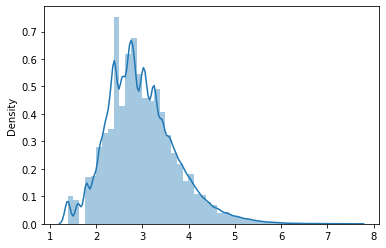

In [ ]:
import seaborn as sns

sns.distplot(y_test)

In [ ]:
len(train_df['brand_name'].value_counts())

4598

In [ ]:
train_df['brand_name'].value_counts()

and                           155153
all                           116920
pink                           44243
nike                           43629
victoria_s_secret              38470
                               ...  
midway                             1
rage_broadheads                    1
positive_attitude                  1
belle_by_sigerson_morrison         1
reference_point                    1
Name: brand_name, Length: 4598, dtype: int64

In [ ]:
i = np.array(train_df['brand_name'].value_counts().index)
c = np.array(train_df['brand_name'].value_counts().values)

d = pd.DataFrame({"brand_name":i, "count":c})
d

,brand_name,count
0,and,155153
1,all,116920
2,pink,44243
3,nike,43629
4,victoria_s_secret,38470
...,...,...
4593,midway,1
4594,rage_broadheads,1
4595,positive_attitude,1
4596,belle_by_sigerson_morrison,1


In [ ]:
d[d['count']==6]

,brand_name,count
2180,sole_society,6
2181,only_mine,6
2182,max_edition,6
2183,michael_antonio,6
2184,florsheim,6
...,...,...
2321,balboa_baby,6
2322,barneys_new_york,6
2323,first_aid_beauty,6
2324,mario_badescu_skin_care,6


# ANN Model

## CNN

In [ ]:
## Custom Tokenizer

In [ ]:
class CustomTokenizer():

  def __init__(self, min_df, max_len):
    self.min_df = min_df
    self.vect = CountVectorizer(lowercase=True, ngram_range=(1,1), stop_words='english', min_df=self.min_df, )
    self.vocabulary = None
    self.max_len = max_len

  def fit(self, corpus):
    self.vect.fit(corpus)
    self.vocabulary = self.vect.vocabulary_

  def transform(self, corpus):
    """
    from a sentence the words with min_freq=self.min_df will be kept, then will be transformed to sequence
    """
    trans_seq = []

    for sent in corpus:

      tokens = sent.lower().split()
      new_sent = []

      for token in tokens:
        if token in self.vocabulary:
          new_sent.append(self.vocabulary[token])
      ## padding
      if len(new_sent) > self.max_len:
        trans_seq.append(np.array(new_sent[:self.max_len]))
      else:
        while len(new_sent) != self.max_len:
          new_sent.append(0)
        trans_seq.append(np.array(new_sent))

    return np.array(trans_seq)

  def getVocab(self):
    return self.vocabulary
        

In [ ]:
## name

In [ ]:
tr = train_df['name'] 
te = test_df['name']

tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)

tokenizer.fit_on_texts(tr)
vocab_name = len(tokenizer.word_index) + 1

train_name = tokenizer.texts_to_sequences(tr)
test_name  = tokenizer.texts_to_sequences(te)

train_name_padded = pad_sequences(train_name, maxlen=16, padding='post')
test_name_padded = pad_sequences(test_name, maxlen=16, padding='post')

del train_name
del test_name

In [ ]:
## desc

In [ ]:
tr = train_df['item_description'] 
te = test_df['item_description']

tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)

tokenizer.fit_on_texts(tr)
vocab_desc = len(tokenizer.word_index) + 1

train_desc = tokenizer.texts_to_sequences(tr)
test_desc  = tokenizer.texts_to_sequences(te)

train_desc_padded = pad_sequences(train_desc, maxlen=160, padding='post')
test_desc_padded = pad_sequences(test_desc, maxlen=160, padding='post')

del train_desc
del test_desc


In [ ]:
## brand

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['brand_name']
te = test_df['brand_name']

tokenizer.fit_on_texts(tr)

vocab_brand = len(tokenizer.word_index)+1

train_brand = tokenizer.texts_to_sequences(tr)
test_brand  = tokenizer.texts_to_sequences(te)

train_brand_padded = pad_sequences(train_brand, maxlen=1, padding='post')
test_brand_padded = pad_sequences(test_brand, maxlen=1, padding='post')


In [ ]:
## category_name

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['category_name'].replace("\s+", "_", regex=True) 
te = test_df['category_name'].replace("\s+", "_", regex=True) 

tokenizer.fit_on_texts(tr)

vocab_cat = len(tokenizer.word_index)+1

train_cat = tokenizer.texts_to_sequences(tr)
test_cat  = tokenizer.texts_to_sequences(te)

train_cat_padded = pad_sequences(train_cat, maxlen=1, padding='post')
test_cat_padded = pad_sequences(test_cat, maxlen=1, padding='post')


In [ ]:
## cat1

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_1'] 
te = test_df['cat_1'] 

tokenizer.fit_on_texts(tr)

vocab_cat1 = len(tokenizer.word_index)+1

train_cat1 = tokenizer.texts_to_sequences(tr)
test_cat1  = tokenizer.texts_to_sequences(te)

train_cat1_padded = pad_sequences(train_cat1, maxlen=1, padding='post')
test_cat1_padded = pad_sequences(test_cat1, maxlen=1, padding='post')


In [ ]:
## cat2

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_2'] 
te = test_df['cat_2'] 

tokenizer.fit_on_texts(tr)

vocab_cat2 = len(tokenizer.word_index)+1

train_cat2 = tokenizer.texts_to_sequences(tr)
test_cat2  = tokenizer.texts_to_sequences(te)

train_cat2_padded = pad_sequences(train_cat2, maxlen=1, padding='post')
test_cat2_padded = pad_sequences(test_cat2, maxlen=1, padding='post')


In [ ]:
## cat3

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_3'] 
te = test_df['cat_3'] 

tokenizer.fit_on_texts(tr)

vocab_cat3 = len(tokenizer.word_index)+1

train_cat3 = tokenizer.texts_to_sequences(tr)
test_cat3  = tokenizer.texts_to_sequences(te)

train_cat3_padded = pad_sequences(train_cat3, maxlen=1, padding='post')
test_cat3_padded = pad_sequences(test_cat3, maxlen=1, padding='post')


In [ ]:
## shipping

In [ ]:

train_shipping = train_df['shipping'].to_numpy().reshape(-1,1)
test_shipping  = test_df['shipping'].to_numpy().reshape(-1, 1)


In [ ]:
## item condition

In [ ]:
vect = OneHotEncoder()
train_cond = vect.fit_transform(train_df['item_condition_id'].to_numpy().reshape(-1,1)).A
test_cond = vect.transform(test_df['item_condition_id'].to_numpy().reshape(-1, 1)).A

In [ ]:
## concatenating features

In [ ]:

X_train = [train_name_padded, train_desc_padded,
           
           train_brand_padded, train_cat_padded,
           
           train_cat1_padded, train_cat2_padded, train_cat3_padded,
           
           train_shipping, train_cond,
           
           ]


X_test = [test_name_padded, test_desc_padded,
          
          test_brand_padded, test_cat_padded,
          
          test_cat1_padded, test_cat2_padded, test_cat3_padded,
          
          test_shipping, test_cond,]



In [ ]:
## CNN Model

In [ ]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv1D


name = Input(shape=(16,), name="name")
desc = Input(shape=(160,), name="desc")
brand = Input(shape=(1,), name="brand")
cat = Input(shape=(1,), name="cat")
cat1 = Input(shape=(1,), name="cat1")
cat2 = Input(shape=(1,), name="cat2")
cat3 = Input(shape=(1,), name="cat3")
ship = Input(shape=(1,), name="ship")
cond = Input(shape=(5,), name="cond")

name_embd = Embedding(input_dim=vocab_name, output_dim=35, name="name_embd") (name)
desc_embd = Embedding(input_dim=vocab_desc, output_dim=45, name="desc_embd") (desc)
brand_embd = Embedding(input_dim=vocab_brand, output_dim=10, name="brand_embd") (brand)
cat_embd = Embedding(input_dim=vocab_cat, output_dim=10, name="cat_embd") (cat)
cat1_embd = Embedding(input_dim=vocab_cat1, output_dim=10, name="cat1_embd") (cat1)
cat2_embd = Embedding(input_dim=vocab_cat2, output_dim=10, name="cat2_embd") (cat2)
cat3_embd = Embedding(input_dim=vocab_cat3, output_dim=10, name="cat3_embd") (cat3)
ship_embd = Embedding(input_dim=3, output_dim=10, name="ship_embd") (ship)
cond_embd = Embedding(input_dim=6, output_dim=10, name="cond_embd") (cond)


name_conv = Conv1D(filters=12, kernel_size=3) (name_embd)
desc_conv = Conv1D(filters=12, kernel_size=3) (desc_embd)

name_drop = Dropout(0.3)(name_conv)
desc_drop = Dropout(0.3)(desc_conv)

name_flat = Flatten()(name_drop)
desc_flat = Flatten()(desc_drop)
brand_flat = Flatten()(brand_embd)
cat_flat = Flatten() (cat_embd)
cat1_flat = Flatten() (cat1_embd)
cat2_flat = Flatten() (cat2_embd)
cat3_flat = Flatten() (cat3_embd)

concat = concatenate(inputs=[name_flat, desc_flat, brand_flat, cat_flat, cat1_flat, cat2_flat, cat3_flat, ship, cond])

out = Dense(100, activation='relu')(concat)
out = Dense(1)(out)

model = Model([name, desc, brand, cat, cat1, cat2, cat3, ship, cond,], out)


model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 16)]         0                                            
__________________________________________________________________________________________________
desc (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
name_embd (Embedding)           (None, 16, 35)       3278380     name[0][0]                       
__________________________________________________________________________________________________
desc_embd (Embedding)           (None, 160, 45)      6454710     desc[0][0]                       
______________________________________________________________________________________________

In [ ]:
opt = keras.optimizers.Adam(lr=0.002)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
for batch in [2000, 1000, 1000, 500,]:

  model.fit(X_train, y, batch_size=batch, epochs=1,
                                    verbose=1,
                                    validation_data=(X_test, y_test),
                                  shuffle=True,callbacks=[])

2371/2371 [==============================] - 237s 100ms/step - loss: 0.1713 - root_mean_squared_error: 0.4139 - val_loss: 0.2008 - val_root_mean_squared_error: 0.4481


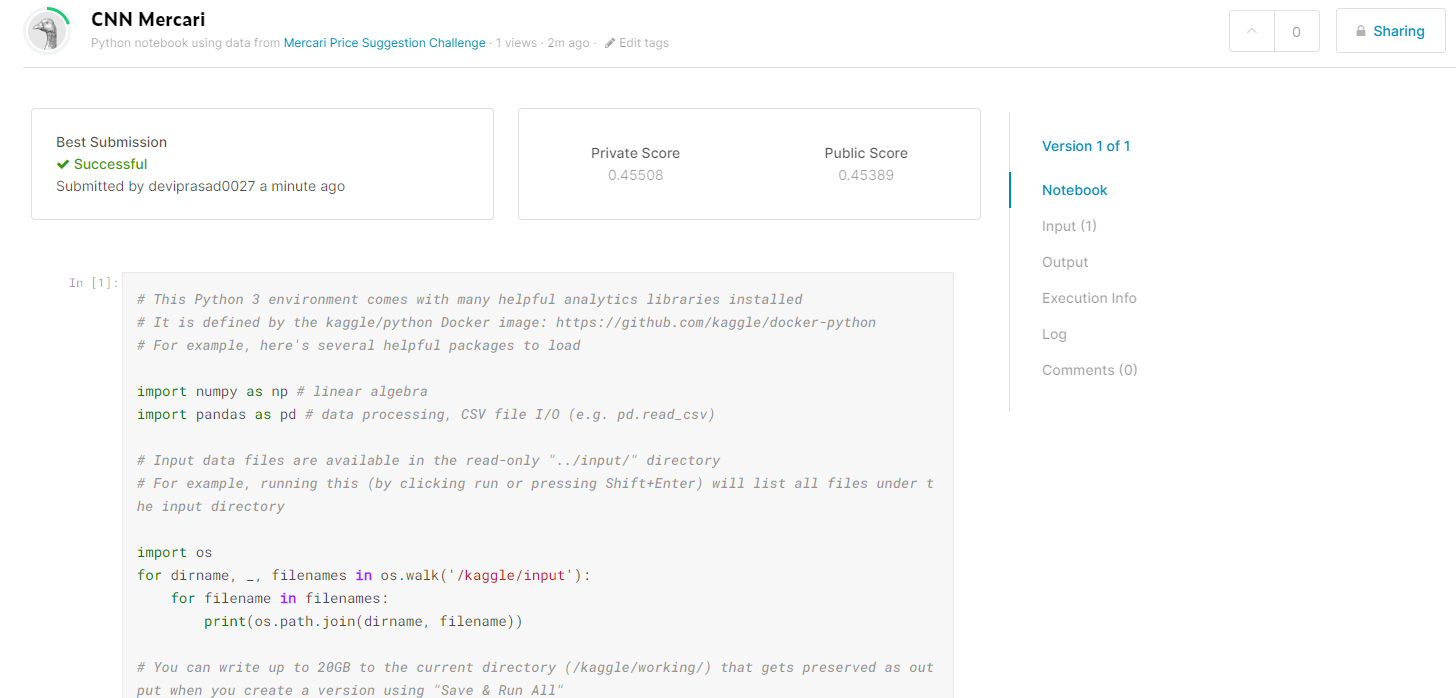

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/CASE STUDY - 1/submission/cnn/CNN Mercari.PNG') 